In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import datetime as dt
from operator import attrgetter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
sns.set_style("white")

In [2]:
mcc_codes = pd.read_excel('merchant codes list.xls', sheet_name='MCC List', header=1, usecols=[0,1])
mcc_codes.rename(columns={'MCC CODE':'mcc_id', 'Program Type:':'program_type'}, inplace=True)
cust = pd.read_csv('customers_sample.csv', sep = ';')
trans = pd.read_csv('transactional_data.csv')

### 1. Analyze the data. What features are there in the dataset? Which of them may be useful for the segmentation? Clean the dataset if needed (1 points).

Determine the number of empty entries. Only those who have registered but have never logged in remain in question. Until we remove them 

In [3]:
cust.dropna().shape

(9675, 10)

In [4]:
cust = cust.dropna()

In [5]:
cust['registration_dt'] = pd.to_datetime(cust['registration_dt'])
cust['Year'] = cust['registration_dt'].dt.year
cust['Month'] =  cust['registration_dt'].dt.month
cust['YearMonth'] = cust['registration_dt'].map(lambda x: 100*x.year + x.month)

In [6]:
print(trans.isna().sum())

uid1               0
date_pur           0
mcc_id             0
transaction_amt    0
transaction_qty    0
dtype: int64


In [7]:
trans['date_pur'] = pd.to_datetime(trans['date_pur'])
trans['Year'] = trans['date_pur'].dt.year
trans['Month'] =  trans['date_pur'].dt.month
trans['YearMonth'] = trans['date_pur'].map(lambda x: 100*x.year + x.month)

In [8]:
# Number of negative
trans.transaction_amt[trans.transaction_amt < 0 ].count()

168863

In [9]:
# remove returns
trans = trans.loc[trans['transaction_amt'] > 0 ]

In [10]:
df = pd.merge(trans, mcc_codes, on='mcc_id', how='left')

### 2. Use the cohorts to analyze the customers activity in dynamics. What can be said about the customers behavior? (1.5 points)

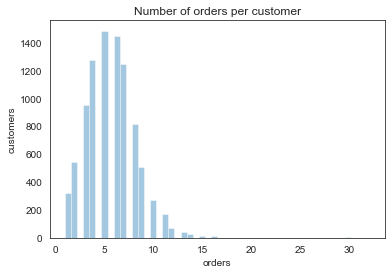

In [11]:
# Долполнительный график распределения активности покупателей
n_orders = df.groupby(['uid1'])['transaction_qty'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['uid1'].nunique()
# График активности покупателей
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Number of orders per customer',
       xlabel='orders', 
       ylabel='customers');

In [12]:
# Cohorts
df['order_month'] = df['date_pur'].dt.to_period('M')
df['cohort'] = df.groupby('uid1')['date_pur'].transform('min').dt.to_period('M')
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('uid1', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
cohort,,,,,,,,,,,,,,,,,,,,,
2020-01,6382.0,6161.0,6135.0,5972.0,5974.0,6036.0,6037.0,6038.0,6027.0,6012.0,...,5919.0,5882.0,5899.0,5894.0,5872.0,5847.0,5798.0,5810.0,5815.0,5460.0
2020-02,257.0,200.0,183.0,188.0,191.0,186.0,190.0,193.0,192.0,195.0,...,196.0,195.0,200.0,198.0,192.0,197.0,195.0,197.0,158.0,NaN
2020-03,175.0,131.0,133.0,126.0,132.0,132.0,128.0,129.0,131.0,138.0,...,133.0,135.0,132.0,131.0,130.0,134.0,134.0,117.0,NaN,NaN
2020-04,92.0,73.0,72.0,68.0,66.0,66.0,67.0,65.0,67.0,66.0,...,64.0,63.0,67.0,66.0,65.0,64.0,53.0,NaN,NaN,NaN
2020-05,90.0,73.0,69.0,71.0,70.0,67.0,62.0,69.0,67.0,66.0,...,69.0,67.0,69.0,67.0,68.0,59.0,NaN,NaN,NaN,NaN
2020-06,70.0,56.0,55.0,57.0,55.0,51.0,50.0,51.0,50.0,52.0,...,52.0,54.0,56.0,53.0,45.0,NaN,NaN,NaN,NaN,NaN
2020-07,97.0,79.0,77.0,80.0,75.0,78.0,75.0,79.0,74.0,73.0,...,71.0,76.0,79.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,93.0,79.0,77.0,74.0,76.0,78.0,77.0,80.0,73.0,74.0,...,76.0,70.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,114.0,100.0,101.0,100.0,97.0,93.0,98.0,95.0,91.0,94.0,...,92.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


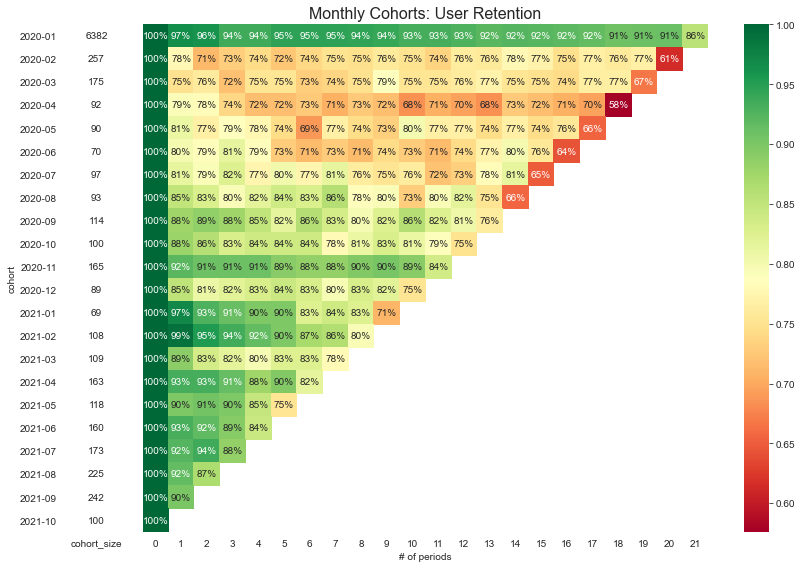

In [13]:
# Output 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

You can see improvements in customer retention in 2021 compared to 2020. 0 is the first purchase, about 90% of fresh customers return. The percentage of return of last year's customers is also quite high 80%. Failures for customers in the 2nd quarter of 2020 should be tried to return.

### 3. Perform the cluster analysis. Choose the optimal number of clusters (should be shown) and features (try various combinations to find the most appropriate one). Generate additional features if they are needed. (1.5 points)

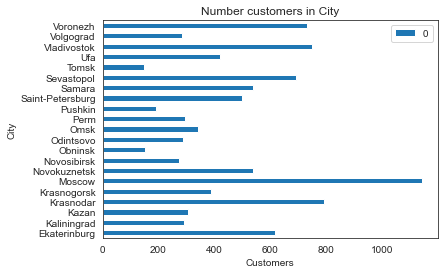

In [14]:
# Number of users by city
cust.groupby(['city_of_living','uid1']).size().reset_index().groupby('city_of_living')[[0]].sum().plot(kind='barh');
plt.title('Number customers in City')
plt.xlabel('Customers');
plt.ylabel('City');

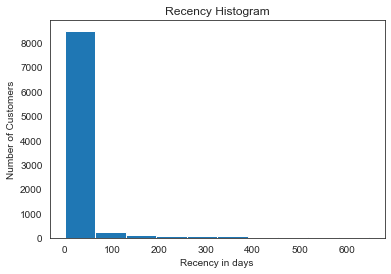

In [15]:
#Create Recency Frequency Monetary (RFM) table
# Recency
customer = pd.DataFrame(df['uid1'].unique())
customer.columns = ['uid1']

recency = df.groupby('uid1').date_pur.max().reset_index()
recency.columns = ['uid1','LastDate']
LastDate = recency['LastDate'].max()

recency['Recency'] = (LastDate - recency['LastDate']).dt.days

customer = pd.merge(customer, recency[['uid1','Recency']], on='uid1')

customer.Recency.plot.hist();
plt.xlabel("Recency in days")
plt.ylabel("Number of Customers")
plt.title("Recency Histogram");

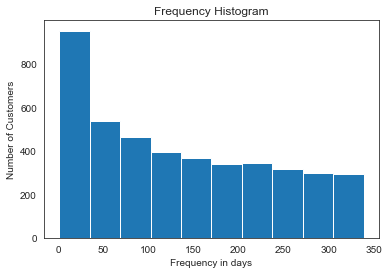

In [16]:
# Frequency
frequency = df.groupby('uid1').date_pur.count().reset_index()
frequency.columns = ['uid1','Frequency']

customer = pd.merge(customer, frequency, on='uid1')

customer.Frequency.sort_values().head(4300).plot.hist();
plt.xlabel("Frequency in days")
plt.ylabel("Number of Customers")
plt.title("Frequency Histogram");

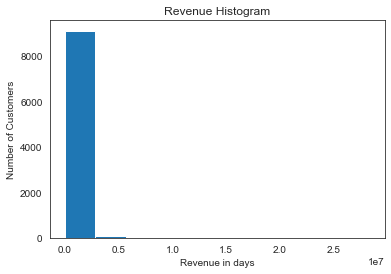

In [17]:
# Monetery Value Score (Revenue)

revenue = df.groupby('uid1').transaction_amt.sum().reset_index()
revenue = df.groupby('uid1').transaction_amt.sum().reset_index()
revenue.columns = ['uid1','Revenue']

customer = pd.merge(customer, revenue, on='uid1')
customer.head()

customer.Revenue.sort_values().plot.hist();
plt.xlabel("Revenue in days")
plt.ylabel("Number of Customers")
plt.title("Revenue Histogram");

In [18]:
customer

,uid1,Recency,Frequency,Revenue
0,14164181,4,618,528136.42
1,15453249,1,458,291660.26
2,41571339,0,1048,491212.41
3,2044223,0,1403,741980.00
4,33493259,6,1132,509306.75
...,...,...,...,...
9186,10384363,159,1,3000.00
9187,34251901,0,1,2999.88
9188,24469823,18,1,286.00
9189,45388263,624,1,363.03


In [19]:
# K-Means Clustering
X = customer.loc[:, 'Recency':'Revenue']
X

,Recency,Frequency,Revenue
0,4,618,528136.42
1,1,458,291660.26
2,0,1048,491212.41
3,0,1403,741980.00
4,6,1132,509306.75
...,...,...,...
9186,159,1,3000.00
9187,0,1,2999.88
9188,18,1,286.00
9189,624,1,363.03


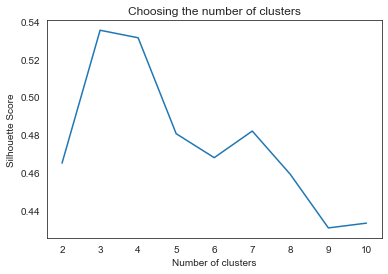

In [20]:
# 6 Segments
scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# K-Means optimization
inertias = []
ss = []
for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(Xstd)
    inertias.append(kmeans.inertia_)
    ss.append(metrics.silhouette_score(Xstd, kmeans.labels_, metric='euclidean'))

plt.plot(range(2, 11), ss)
plt.title('Choosing the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

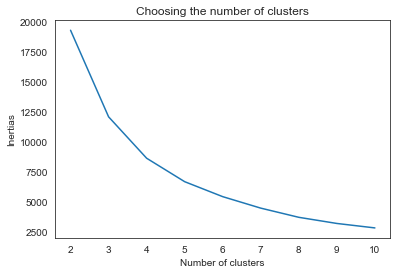

In [21]:
plt.plot(range(2, 11), inertias)
plt.title('Choosing the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

In [22]:
# Результат 3 кластера( ну тут короче под вопросом можно поиграть n_clusters)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(Xstd)
y_kmeans = kmeans.predict(Xstd)

cluster_labels = kmeans.labels_
print("Assigned cluster labels: \n", cluster_labels)

centroids = kmeans.cluster_centers_
print("Location of centroids: ")
print(centroids)

Xstd['clusters'] = cluster_labels
Xstd.head()

Assigned cluster labels: 
 [0 0 1 ... 0 2 0]
Location of centroids: 
[[-0.14415144 -0.47117333 -0.28491615]
 [-0.26714468  1.30049939  0.77482193]
 [ 4.46761111 -0.94363248 -0.48776307]]


,Recency,Frequency,Revenue,clusters
0,-0.235015,0.378345,0.156245,0
1,-0.272882,-0.017206,-0.165718,0
2,-0.285504,1.441390,0.105973,1
3,-0.285504,2.319020,0.447393,1
4,-0.209770,1.649055,0.130608,1


In [23]:
# Анализ кластеров
Xstd['ID'] = Xstd.index
clus = pd.melt(Xstd.reset_index(),
                      id_vars=['ID', 'clusters'],
                      value_vars=['Recency','Frequency','Revenue'],
                      var_name='Attribute',
                      value_name='Value')
clus.head()

,ID,clusters,Attribute,Value
0,0,0,Recency,-0.235015
1,1,0,Recency,-0.272882
2,2,1,Recency,-0.285504
3,3,1,Recency,-0.285504
4,4,1,Recency,-0.209770


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

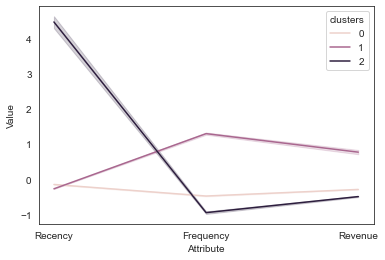

In [24]:
sns.lineplot('Attribute', 'Value', hue='clusters', data=clus)

In [25]:
fig3 = clus.groupby('clusters').agg({'ID': lambda x: len(x)}).reset_index()
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)
# В процентах распределение
fig3.head()

,clusters,Count,percent
0,0,18870,68.4
1,1,7638,27.7
2,2,1065,3.9


In [26]:
customer['clusters'] = cluster_labels

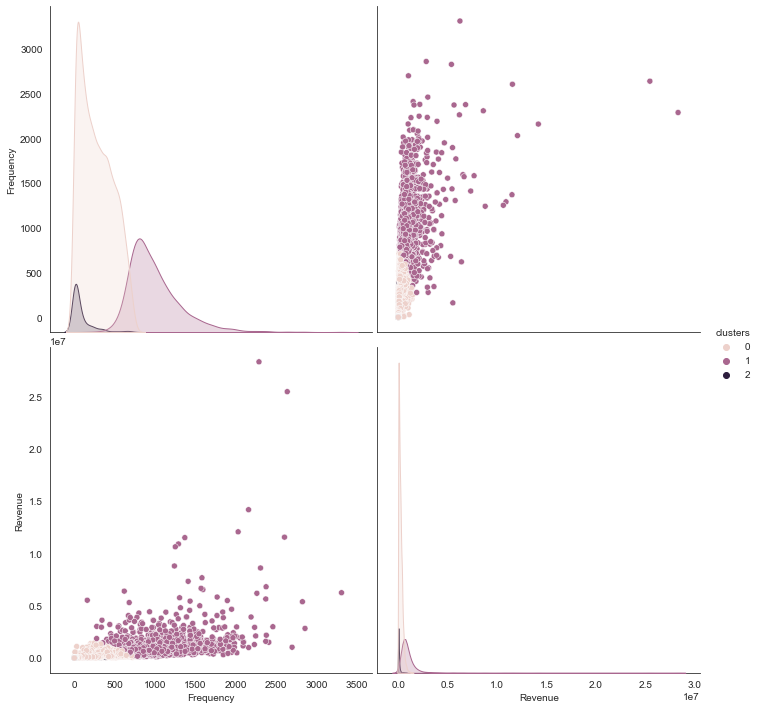

In [27]:
sns.pairplot(customer[['Frequency', 'Revenue', 'clusters']], hue="clusters", size=5)

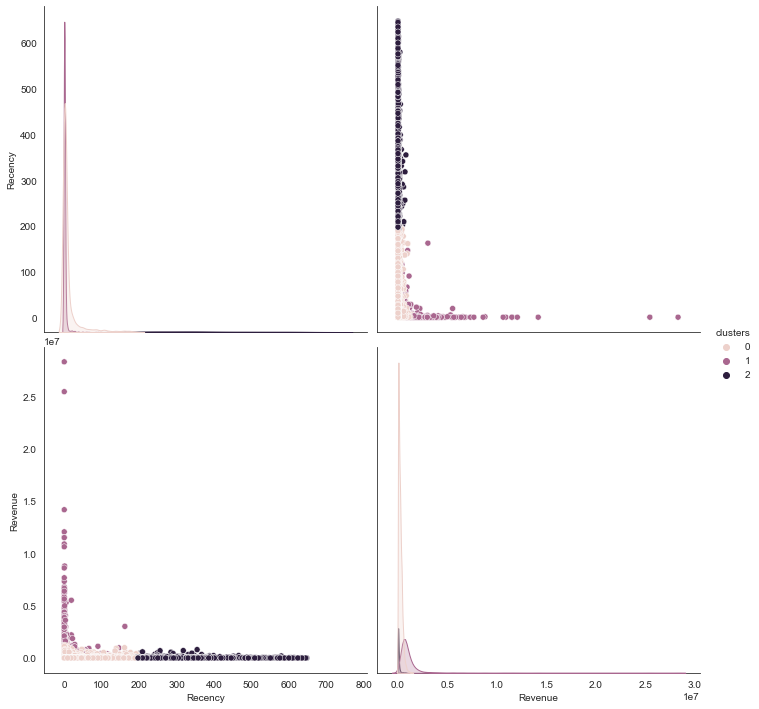

In [28]:
sns.pairplot(customer[['Recency', 'Revenue', 'clusters']], hue="clusters", size=5)

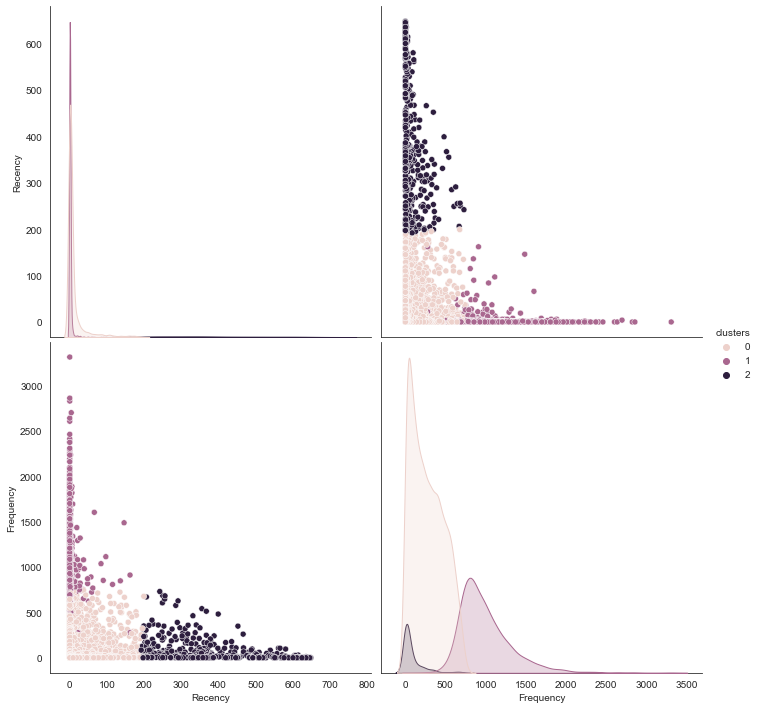

In [29]:
sns.pairplot(customer[['Recency', 'Frequency', 'clusters']], hue="clusters", size=5)

In [30]:
# cluster_num = customer['clusters'].values
# for i in cluster_num:
#     subset = customer[customer['clusters'] == i]
#     sns.distplot(subset['Recency'], hist = False, kde = True,
#                      kde_kws = {'shade': True, 'linewidth': 3}, 
#                       label = customer['clusters'].values)

In [31]:
customer = pd.merge(customer, cust, on='uid1', how='left')
customer.to_csv('segmentation.csv')

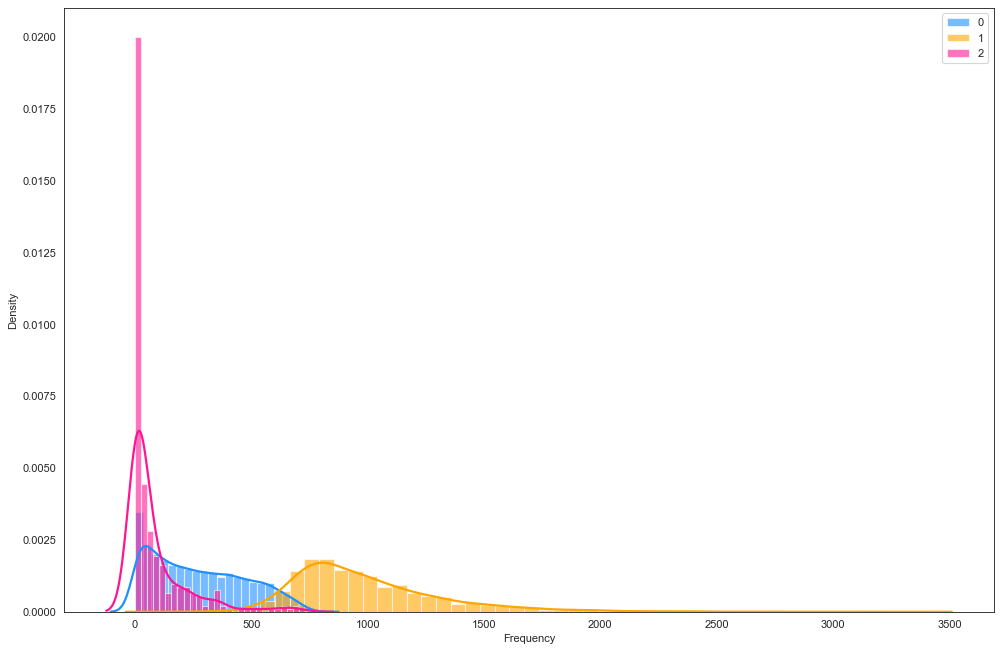

In [32]:
x1 = customer.loc[customer.clusters== 0, 'Frequency']
x2 = customer.loc[customer.clusters== 1, 'Frequency']
x3 = customer.loc[customer.clusters== 2, 'Frequency']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(15,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="0", **kwargs)
sns.distplot(x2, color="orange", label="1", **kwargs)
sns.distplot(x3, color="deeppink", label="2", **kwargs)
plt.legend();

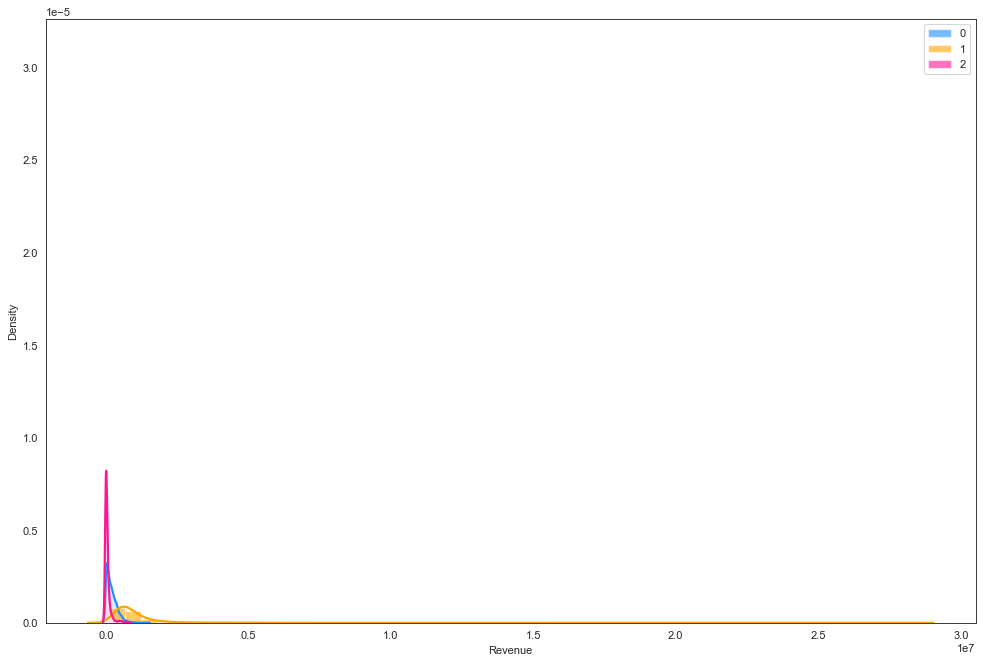

In [33]:
x1 = customer.loc[customer.clusters== 0, 'Revenue']
x2 = customer.loc[customer.clusters== 1, 'Revenue']
x3 = customer.loc[customer.clusters== 2, 'Revenue']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(15,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="0", **kwargs)
sns.distplot(x2, color="orange", label="1", **kwargs)
sns.distplot(x3, color="deeppink", label="2", **kwargs)
plt.legend();

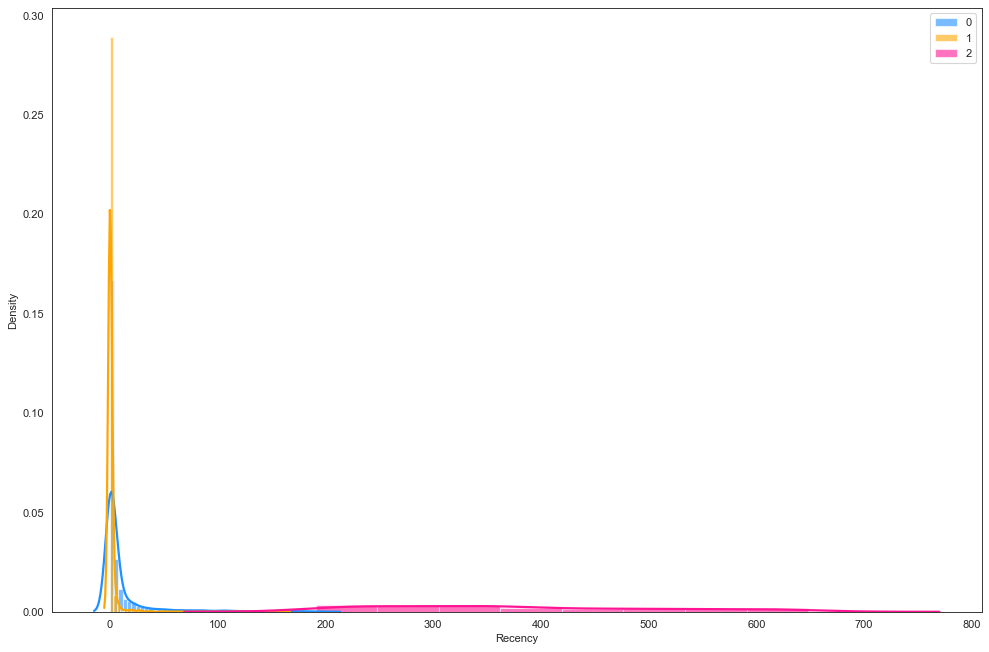

In [34]:
x1 = customer.loc[customer.clusters== 0, 'Recency']
x2 = customer.loc[customer.clusters== 1, 'Recency']
x3 = customer.loc[customer.clusters== 2, 'Recency']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(15,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="0", **kwargs)
sns.distplot(x2, color="orange", label="1", **kwargs)
sns.distplot(x3, color="deeppink", label="2", **kwargs)
plt.legend();

In [35]:
customer

,uid1,Recency,Frequency,Revenue,clusters,customer_age,country,city_of_living,registration_dt,website_last_visit_date,email,has_mob_app,phone_number,push,Year,Month,YearMonth
0,14164181,4,618,528136.42,0,50.0,RUSSIA,Samara,2017-05-12,14.12.2019,1.0,1.0,1.0,1.0,2017.0,5.0,201705.0
1,15453249,1,458,291660.26,0,63.0,RUSSIA,Perm,2017-07-11,08.05.2019,0.0,0.0,1.0,0.0,2017.0,7.0,201707.0
2,41571339,0,1048,491212.41,1,22.0,RUSSIA,Novokuznetsk,2019-11-13,06.09.2020,0.0,1.0,1.0,1.0,2019.0,11.0,201911.0
3,2044223,0,1403,741980.00,1,33.0,RUSSIA,Voronezh,2018-10-13,08.05.2020,0.0,0.0,1.0,0.0,2018.0,10.0,201810.0
4,33493259,6,1132,509306.75,1,24.0,RUSSIA,Voronezh,2016-09-30,27.07.2018,1.0,0.0,1.0,0.0,2016.0,9.0,201609.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,10384363,159,1,3000.00,0,50.0,RUSSIA,Perm,2020-08-29,21.04.2021,1.0,0.0,1.0,0.0,2020.0,8.0,202008.0
9187,34251901,0,1,2999.88,0,41.0,RUSSIA,Volgograd,2021-06-10,07.10.2021,0.0,0.0,1.0,0.0,2021.0,6.0,202106.0
9188,24469823,18,1,286.00,0,34.0,RUSSIA,Ekaterinburg,2015-01-30,12.11.2020,1.0,0.0,1.0,0.0,2015.0,1.0,201501.0
9189,45388263,624,1,363.03,2,29.0,RUSSIA,Volgograd,2015-05-18,01.08.2016,1.0,0.0,1.0,0.0,2015.0,5.0,201505.0


## 4. Describe the customers in each cluster. Which significant characteristics can be underlined?

In [36]:
#count customers
segments = customer.groupby('clusters')['uid1'].count().sort_values(ascending=False)
segments.head()

clusters
0    6290
1    2546
2     355
Name: uid1, dtype: int64

In [37]:
#average age
age = customer.groupby('clusters')['customer_age'].mean().sort_values(ascending=False)
age.head()

clusters
2    48.449704
0    43.288108
1    38.562954
Name: customer_age, dtype: float64

In [38]:
#push, mobile phones, email for claster 0
claster_0 = customer['clusters'] == 0
print('customers with email: ' + str(int(customer['email'][claster_0].sum())) + ' which is ' + 
str(round(int(customer['email'][claster_0].sum()) / customer['uid1'][claster_0].count() * 100)) + '%' )

print('customers with mobile app: ' + str(int(customer['has_mob_app'][claster_0].sum())) + ' which is ' +
str(round(int(customer['has_mob_app'][claster_0].sum()) / customer['uid1'][claster_0].count() * 100)) + '%')

print('customers with phone number: ' + str(int(customer['phone_number'][claster_0].sum())) + ' which is ' +
str(int(customer['phone_number'][claster_0].sum()) / customer['uid1'][claster_0].count() * 100) + '%')

print('customers with push notifications: ' + str(int(customer['push'][claster_0].sum())) + ' which is ' + 
str(round(int(customer['push'][claster_0].sum()) / customer['uid1'][claster_0].count() * 100)) + '%')

print('overall customers in segment:', customer['uid1'][claster_0].count())

customers with email: 883 which is 14%
customers with mobile app: 1320 which is 21%
customers with phone number: 6075 which is 96.5818759936407%
customers with push notifications: 846 which is 13%
overall customers in segment: 6290


In [39]:
#push, mobile phones, email for claster 1
claster_1 = customer['clusters'] == 1
print('customers with email: ' + str(int(customer['email'][claster_1].sum())) + ' which is ' + 
str(round(int(customer['email'][claster_1].sum()) / customer['uid1'][claster_1].count() * 100)) + '%' )

print('customers with mobile app: ' + str(int(customer['has_mob_app'][claster_1].sum())) + ' which is ' +
str(round(int(customer['has_mob_app'][claster_1].sum()) / customer['uid1'][claster_1].count() * 100)) + '%')

print('customers with phone number: ' + str(int(customer['phone_number'][claster_1].sum())) + ' which is ' +
str(int(customer['phone_number'][claster_1].sum()) / customer['uid1'][claster_1].count() * 100) + '%')

print('customers with push notifications: ' + str(int(customer['push'][claster_1].sum())) + ' which is ' + 
str(round(int(customer['push'][claster_1].sum()) / customer['uid1'][claster_1].count() * 100)) + '%')

print('overall customers in segment:', customer['uid1'][claster_1].count())

customers with email: 724 which is 28%
customers with mobile app: 971 which is 38%
customers with phone number: 2468 which is 96.9363707776905%
customers with push notifications: 633 which is 25%
overall customers in segment: 2546


In [40]:
#push, mobile phones, email for claster 2
claster_2 = customer['clusters'] == 2
print('customers with email: ' + str(int(customer['email'][claster_2].sum())) + ' which is ' + 
str(round(int(customer['email'][claster_2].sum()) / customer['uid1'][claster_2].count() * 100)) + '%' )

print('customers with mobile app: ' + str(int(customer['has_mob_app'][claster_2].sum())) + ' which is ' +
str(round(int(customer['has_mob_app'][claster_2].sum()) / customer['uid1'][claster_2].count() * 100)) + '%')

print('customers with phone number: ' + str(int(customer['phone_number'][claster_2].sum())) + ' which is ' +
str(int(customer['phone_number'][claster_2].sum()) / customer['uid1'][claster_2].count() * 100) + '%')

print('customers with push notifications: ' + str(int(customer['push'][claster_2].sum())) + ' which is ' + 
str(round(int(customer['push'][claster_2].sum()) / customer['uid1'][claster_2].count() * 100)) + '%')

print('overall customers in segment:', customer['uid1'][claster_2].count())

customers with email: 72 which is 20%
customers with mobile app: 72 which is 20%
customers with phone number: 337 which is 94.92957746478872%
customers with push notifications: 46 which is 13%
overall customers in segment: 355


In [41]:
#Cities
city_0 = customer[claster_0].groupby(['city_of_living'])['city_of_living'].count().sort_values(ascending=False)
city_0.head(5)

city_of_living
Moscow         696
Krasnodar      500
Voronezh       479
Vladivostok    451
Sevastopol     420
Name: city_of_living, dtype: int64

In [42]:
city_1 = customer[claster_1].groupby(['city_of_living'])['city_of_living'].count().sort_values(ascending=False)
city_1.head(5)

city_of_living
Moscow         316
Krasnodar      208
Vladivostok    205
Voronezh       182
Sevastopol     173
Name: city_of_living, dtype: int64

In [43]:
city_2 = customer[claster_2].groupby(['city_of_living'])['city_of_living'].count().sort_values(ascending=False)
city_2.head(5)

city_of_living
Moscow          36
Vladivostok     34
Sevastopol      32
Novokuznetsk    27
Krasnodar       24
Name: city_of_living, dtype: int64

In [44]:
#The year mode
mcc = customer.groupby('clusters')['Year'].agg(pd.Series.mode)
mcc.head()

clusters
0    2021.0
1    2017.0
2    2013.0
Name: Year, dtype: float64

In [45]:
trans.shape

(4273446, 8)

In [46]:
#Which program types most popular
customer_trans = pd.merge(customer, df, on='uid1', how='left')

In [47]:
mcc = customer_trans.groupby('clusters')['program_type'].agg(pd.Series.mode)
mcc.head()

clusters
0    Grocery Stores and Supermarkets
1    Grocery Stores and Supermarkets
2    Grocery Stores and Supermarkets
Name: program_type, dtype: object

In [48]:
cluster_0 = customer_trans['clusters'] == 0
cluster_1 = customer_trans['clusters'] == 1
cluster_2 = customer_trans['clusters'] == 2

In [49]:
mcc_0 = customer_trans[cluster_0].groupby('program_type')['program_type'].count().sort_values(ascending=False)
mcc_0.head()

program_type
Grocery Stores and Supermarkets                                       557289
Miscellaneous Food Stores-Convenience Stores and Specialty Markets    182708
Quick Payment Service-Fast Food Restaurants                           110077
Drug Stores and Pharmacies                                             84734
Package Stores--Beer, Wine, and Liquor                                 75536
Name: program_type, dtype: int64

In [50]:
mcc_1 = customer_trans[cluster_1].groupby('program_type')['program_type'].count().sort_values(ascending=False)
mcc_1.head()

program_type
Grocery Stores and Supermarkets                                       691964
Miscellaneous Food Stores-Convenience Stores and Specialty Markets    235565
Quick Payment Service-Fast Food Restaurants                           219390
Package Stores--Beer, Wine, and Liquor                                135817
Drug Stores and Pharmacies                                            111617
Name: program_type, dtype: int64

In [51]:
mcc_2 = customer_trans[cluster_2].groupby('program_type')['program_type'].count().sort_values(ascending=False)
mcc_2.head()

program_type
Grocery Stores and Supermarkets                                       9503
Miscellaneous Food Stores-Convenience Stores and Specialty Markets    2983
Quick Payment Service-Fast Food Restaurants                           1896
Package Stores--Beer, Wine, and Liquor                                1653
Drug Stores and Pharmacies                                            1477
Name: program_type, dtype: int64

In [52]:
#Popular program types
mcc_all = customer_trans.groupby('program_type')['program_type'].count().sort_values(ascending=False)
mcc_all.head()

program_type
Grocery Stores and Supermarkets                                       1258756
Miscellaneous Food Stores-Convenience Stores and Specialty Markets     421256
Quick Payment Service-Fast Food Restaurants                            331363
Package Stores--Beer, Wine, and Liquor                                 213006
Drug Stores and Pharmacies                                             197828
Name: program_type, dtype: int64

In [53]:
#not popular
mcc_all = customer_trans.groupby('program_type')['program_type'].count().sort_values(ascending=True)
mcc_all.head()

program_type
Towing Services            1
Jugoslav Air               1
Europ Car                  1
Intercontinental Hotels    1
Hotels Melia               1
Name: program_type, dtype: int64

### Clusters overview

Let's describe our clusters.<br>
The main difference between clusters according to RFM criteria.<br>
Cluster 0. Clients who came recently. The frequency of using the application is average. Revenue too. Just came to the bank. They live mainly in Moscow. The average age is over 40. Approximately 1/5 have a mobile application. Push notifications are poorly connected and the little one left an email. They buy mostly groceries.<br>
Cluster 1. Clients who arrived recently, but earlier than cluster 0 clients. They have the highest app usage frequency and the highest Revenue. The average age is less than 40. Mostly they buy in grocery stores. More than a third of the cluster has a mobile application. A quarter of them have push notifications enabled. They live mainly in Moscow.<br>
Cluster 2. Clients who have been for a long time, before anyone else. Lowest Frequency and Revenue. The average age is over 40. There are almost no push notifications. One-fifth have a mobile application. Mostly from Moscow. Mostly bought in grocery stores.

### 5. Choose the KPI (“metrics of success”) for each segment (what can be grown/ decreased/increased), explain your choice. (1 point)


As you can see, the group of customers who most often use the bank brings him a lot of profit. Therefore, for all three groups, KPI - is associated with the frequency of use.<br>
KPI for cluster 0. Increase the frequency of using the bank.<br>
KPI for the cluster 1. Maintain the frequency of using the bank.<br>
KPI for the cluster 2. Increase the frequency of using the bank.<br>

### 6. Think of possible marketing initiatives that could potentially drive the chosen metrics for each segment. Generate 3-5 hypothesis and test them using statistical criteria (remember that we can use parametric criteria like t-test only if the data distribution is known). (2 points)

To increase the activity of our customers, we can offer them cashbacks for their most popular purchases in grocery stores. Set preferential rates for deposits or increased cashback for those who download the application / connect the push / leave an email. Offer preferential terms or monetary rewards for customers who have been with us for a long time but rarely use the application. You can also look for partners for different age categories of our clients. We believe that measures to encourage people to connect to our channels, to renew interest from long-term customers, and to increase offers for older ages will help to improve the frequency of use of the services.

### Hypothesis
The Frequency distribution is not normal. To calculate correlations, we use the Spearman coefficient, to calculate the statistical significance of Bootstap and Kruskal.

In [54]:
import scipy.stats as st

### Hypothesis 1.
Hypothesis H0. The presence of a mobile application does not affect the frequency of purchases.
Hypothesis H1. The presence of a mobile application has a positive effect on the frequency of purchases

In [55]:
df = customer[['Frequency', 'has_mob_app']]
df.corr(method = 'pearson')

,Frequency,has_mob_app
Frequency,1.000000,0.220249
has_mob_app,0.220249,1.000000


Correlation coefficient is positive => H0 is rejected, correlation is positive

### Hypothesis 2.
Hypothesis H0. The presence of email does not affect the frequency of purchases.
Hypothesis H1. The presence of email has a positive effect on the frequency of purchases.

In [56]:
df = customer[['Frequency', 'email']]
df.corr(method = 'pearson')

,Frequency,email
Frequency,1.000000,0.160954
email,0.160954,1.000000


Hypothesis H0 was not confirmed, the correlation coefficient is positive.

### Hypothesis 3.
Hypothesis H0. The presence of push notifications does not affect the frequency of purchases.
Hypothesis H1. The presence of push notifications has a positive effect on the frequency of purchases.

In [57]:
df = customer[['Frequency', 'push']]
df.corr(method = 'pearson')

,Frequency,push
Frequency,1.000000,0.181573
push,0.181573,1.000000


The coefficient is positive, H0 is not correct, the correlation is positive, but the coefficient is less than that of mobile applications.

### Hypothesis 4.
Hypothesis H0. There is no statistical difference in the frequency of purchases between groups of people who came recently from those who used the bank for a long time.
Hypothesis H1. There is a statistical difference in the frequency of purchases between groups of people who came recently from those who have been using the bank for a long time.

In [58]:
!pip install bstrap
from bstrap import bootstrap

In [59]:
customer_old = customer.loc[customer['Year']<=2016]
customer_new = customer.loc[customer['Year']>2016]

In [60]:
st.kruskal(customer_old.Frequency, customer_new.Frequency)

KruskalResult(statistic=173.35772557292225, pvalue=1.3672458146402606e-39)

In [ ]:
bootstrap(np.mean, customer_old.Frequency, customer_new.Frequency)

The p-value < 0.05 then we can consider that H0 should be rejected and there are statistical difference in frequency between old and new customers

### Hypothesis 5.
Hypothesis H0. There is no statistical difference in frequency between customers under and above 40. 
Hypothesis H1.There is statistical difference in frequency between customers under and above 40.

In [ ]:
customer_under_40 = customer.loc[customer['customer_age'] <= 40]
customer_above_40 = customer.loc[customer['customer_age'] > 40]
st.kruskal(customer_under_40.Frequency, customer_above_40.Frequency)

In [ ]:
bootstrap(np.mean, customer_under_40.Frequency, customer_above_40.Frequency, nbr_runs=2000)

The p-value < 0.05 then we can consider that H0 should be rejected and there are statistical difference in frequency between customers under and above 40

## 7. Write the marketing strategy based on the results of hypothesis testing. Don’t forget about the communication channels! Suggest the formats and place of communication message delivery (emails, banners in mobile app, etc.). (2 points)

According to our analysis, the marketing strategy should be aimed at increasing the number of customers with mobile applications. And also to renew the interest of long-standing customers in using the product. You also need to focus your products more on people of different age categories, as they do not behave the same way. <br>
The best channel for communication will be SMS notification, as we have the number of almost all of our clients, unlike other channels. <br>
Customers should more actively switch to the mobile application, so preferential conditions, discounts or prizes should be provided either when downloading the application or otherwise incentivizing its use.
It is possible to attract cashbacks for purchases in grocery stores, since customers spend most often in these places.